In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,64
41,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,61


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 140, 149, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1,
 5,
 33,
 37,
 60,
 64,
 98,
 106,
 140,
 149,
 179,
 180,
 240,
 248,
 253,
 257,
 287,
 309,
 322,
 326]

In [8]:
def plot_similarity_heatmap(dtw_df):
    vis_right_df = play_record_df.copy()
    vis_right_df = vis_right_df[['drummer_name', 'id']]

    vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
    vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
    vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
    vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                      'drummer_name_y': 'b_drummer_name'})
    vis_df['a_id'] = vis_df['a_id'].apply(str)
    vis_df['b_id'] = vis_df['b_id'].apply(str)
    vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
    vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# raw merge

In [9]:
dtw_df = pd.read_csv('dtw_df@raw_merge.csv')
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw
0,1,5,38604.473261,5.275437e+05
1,1,33,50269.976941,6.759640e+05
2,1,37,50390.086244,6.949540e+05
3,1,60,49346.451912,6.502112e+05
4,1,64,49810.081195,6.148629e+05
5,1,98,53714.214401,7.180486e+05
6,1,106,54561.870618,7.822887e+05
7,1,140,54210.275402,6.887328e+05
8,1,149,51864.469730,7.394917e+05
9,1,179,73724.094743,1.040954e+06


In [10]:
SIMILARITY_COLUMNS = list(dtw_df.drop(['a_id', 'b_id'], axis=1).columns)
SIMILARITY_COLUMNS

['acc_dtw', 'gyr_dtw']

In [11]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
0,1,5,-0.557484,-0.690320,-0.623902
1,1,33,0.234333,-0.016342,0.108995
2,1,37,0.242485,0.069891,0.156188
3,1,60,0.171647,-0.133286,0.019180
4,1,64,0.203117,-0.293803,-0.045343
5,1,98,0.468116,0.174764,0.321440
6,1,106,0.525653,0.466478,0.496065
7,1,140,0.501788,0.041641,0.271714
8,1,149,0.342562,0.272137,0.307349
9,1,179,1.826322,1.641078,1.733700


In [12]:
dtw_df[dtw_df['a_id'] == 60]


,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
76,60,1,0.164131,-0.140533,0.011799
77,60,5,-0.093385,-0.272201,-0.182793
78,60,33,-1.637436,-1.647222,-1.642329
79,60,37,-1.619812,-1.632817,-1.626315
80,60,64,-2.313139,-1.868840,-2.090990
81,60,98,-1.421691,-1.183527,-1.302609
82,60,106,-1.300372,-0.917458,-1.108915
83,60,140,-0.828464,-1.584393,-1.206429
84,60,149,-1.831505,-1.585624,-1.708565
85,60,179,0.148473,0.400358,0.274416


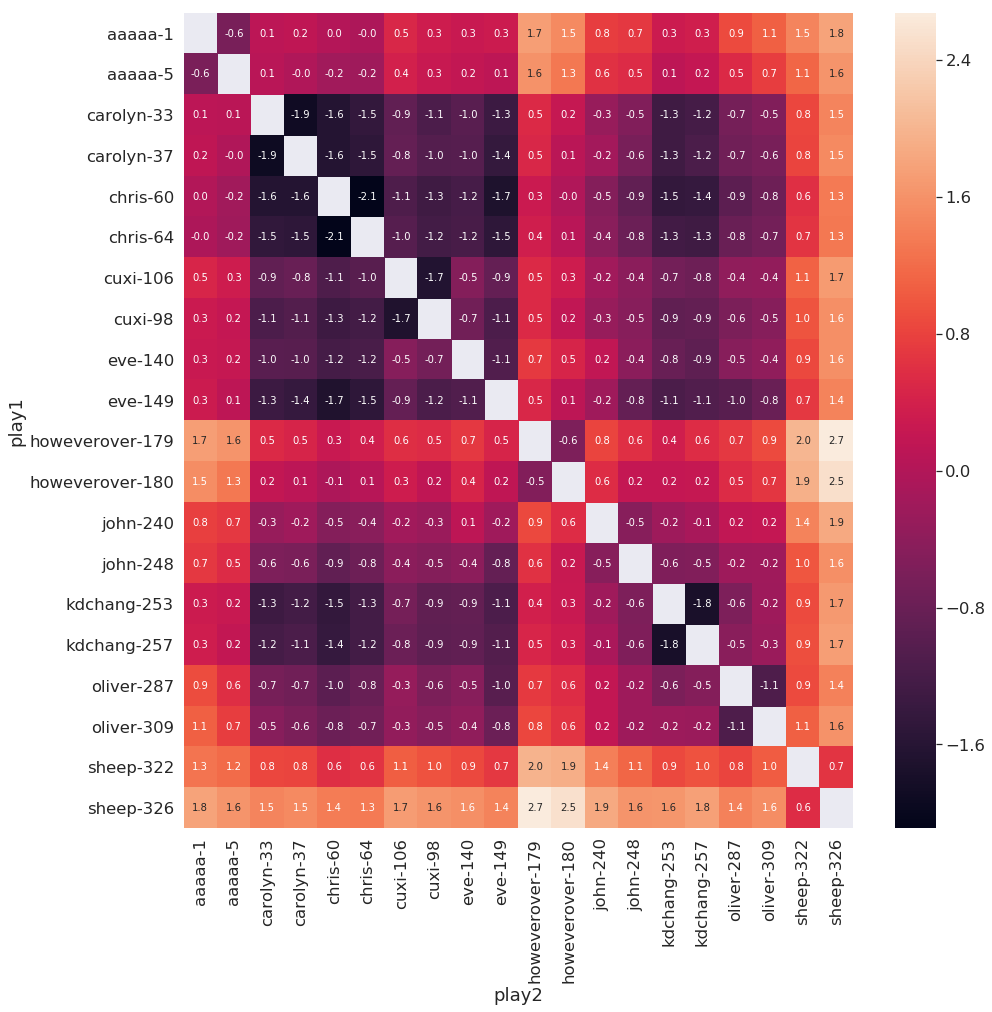

In [13]:
plot_similarity_heatmap(dtw_df)

In [14]:
dtw_df = pd.read_csv('dtw_df@raw_merge.csv')

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
0,1,5,1.755655,1.365331,2.224062
1,1,33,2.547472,2.039308,3.263187
2,1,37,2.555624,2.125542,3.324025
3,1,60,2.484786,1.922365,3.141599
4,1,64,2.516255,1.761848,3.071750
5,1,98,2.781255,2.230415,3.565127
6,1,106,2.838791,2.522129,3.797351
7,1,140,2.814926,2.097292,3.510334
8,1,149,2.655701,2.327788,3.531479
9,1,179,4.139461,3.696728,5.549859


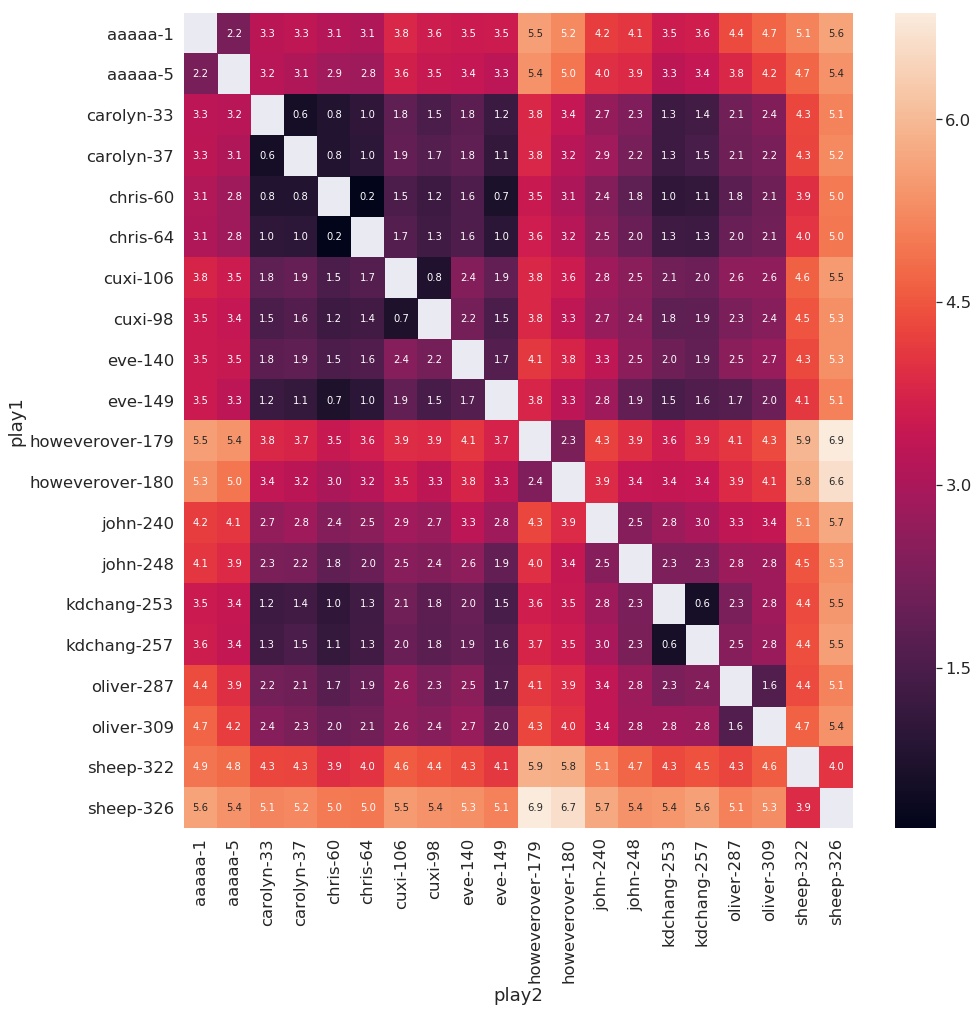

In [15]:
plot_similarity_heatmap(dtw_df)

# raw merge euc

In [16]:
dtw_df = pd.read_csv('dtw_df@raw_merge_euc.csv')
dtw_df

,a_id,b_id,acc_l2,gyr_l2
0,1,5,951.566307,11995.299477
1,1,33,824.696066,10965.476183
2,1,37,812.941821,10797.554627
3,1,60,796.202500,10788.338485
4,1,64,776.095575,10167.307360
5,1,98,873.839400,11471.108054
6,1,106,880.693388,12291.626893
7,1,140,842.749552,10671.906421
8,1,149,796.969520,11040.058375
9,1,179,1099.292961,14465.816593


In [17]:
SIMILARITY_COLUMNS = list(dtw_df.drop(['a_id', 'b_id'], axis=1).columns)
SIMILARITY_COLUMNS

['acc_l2', 'gyr_l2']

In [18]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,acc_l2,gyr_l2,norm_sim
0,1,5,0.794329,0.713659,0.753994
1,1,33,0.261853,0.370305,0.316079
2,1,37,0.212520,0.314319,0.263419
3,1,60,0.142265,0.311246,0.226756
4,1,64,0.057876,0.104188,0.081032
5,1,98,0.468108,0.538888,0.503498
6,1,106,0.496874,0.812457,0.654666
7,1,140,0.337624,0.272426,0.305025
8,1,149,0.145484,0.395172,0.270328
9,1,179,1.414339,1.537355,1.475847


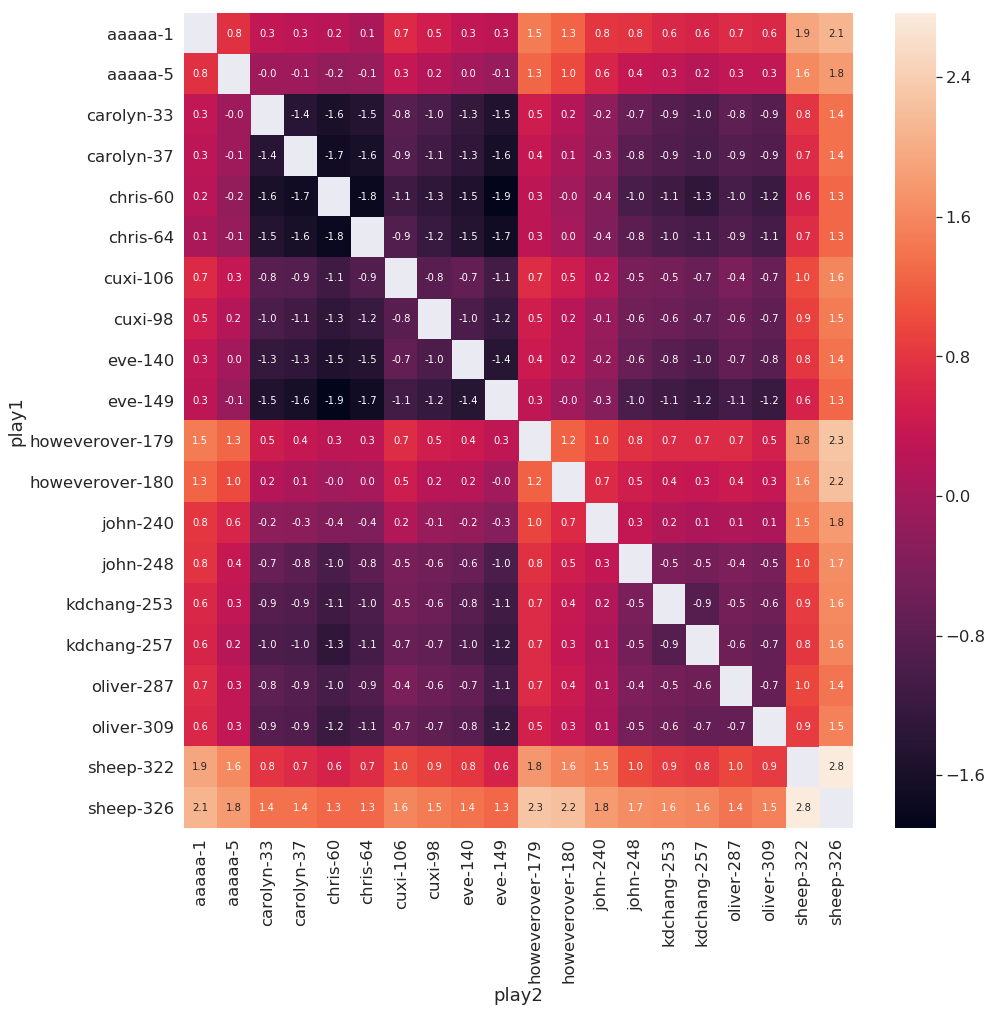

In [19]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')